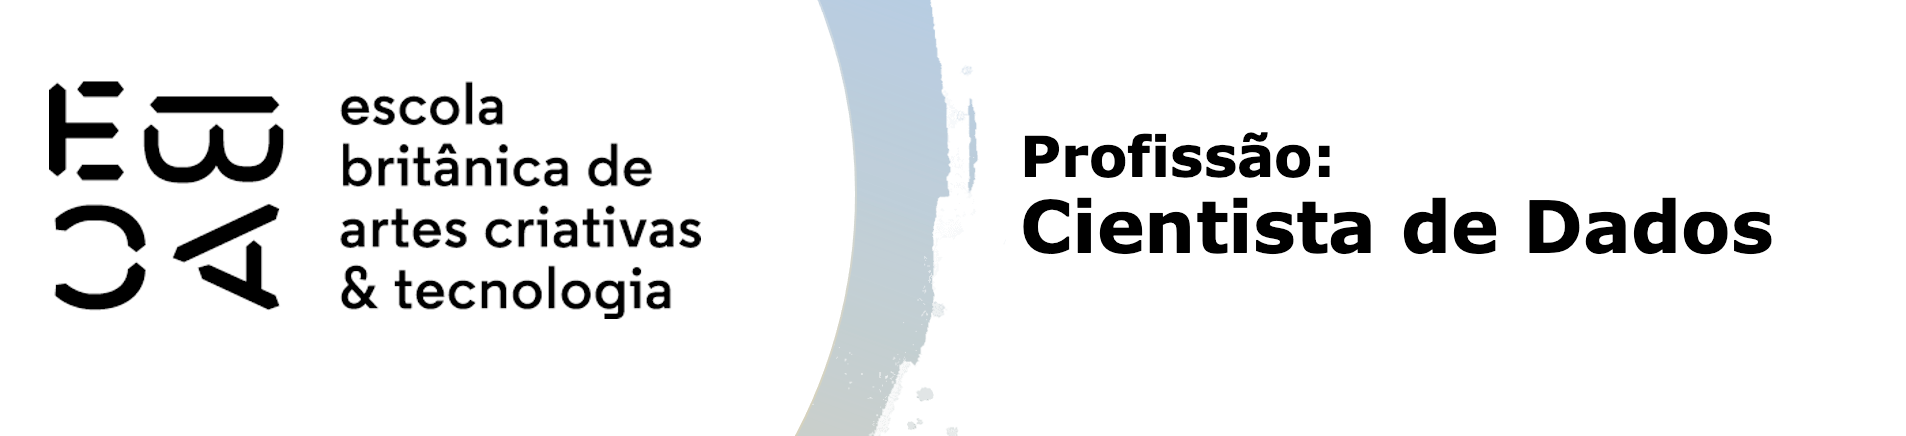

# Online Shoppers purchase intention - Kmeans analysis.

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - **"Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"**

**Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos.**

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

#### Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

#### Carregamento da base

In [2]:
# carrega a base
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### Função principal para análise descritiva preliminar

In [3]:
# caracterização do seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style='white', rc=custom_params)

# funcão principal para análise descritiva
def main_analise(df: pd.DataFrame) -> None:


    print(f'Colunas: {df.shape[1]}, Linhas: {df.shape[0]}')
    # verifica se há dados faltantes
    if True in df.isna().any().to_list():
        print('Há dados faltantes. Verificar')
    else:
        print('Não há dados faltantes.\n')

    # verifica o tipo de dados
    print(df.dtypes)
  
    # Seleciona as seis primeiras variáveis como 'features'
    X = df.iloc[:, :6]

    # boxplot
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axs = axs.flatten()
    
    for i, col in enumerate(X.columns):
        ax = axs[i]
        sns.boxplot(x=df['Revenue'], y=X[col], ax=ax)
        ax.set_title(col)

    plt.tight_layout()
    plt.show()

    # histogramas
    fig_1, axs_1 = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axs_1 = axs_1.flatten()

    for i, col in enumerate(X.columns):
        ax = axs_1[i]
        sns.histplot(data=df, x=col, hue='Revenue', kde=True, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()

    return None

#### Análise

Colunas: 18, Linhas: 12330
Não há dados faltantes.

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


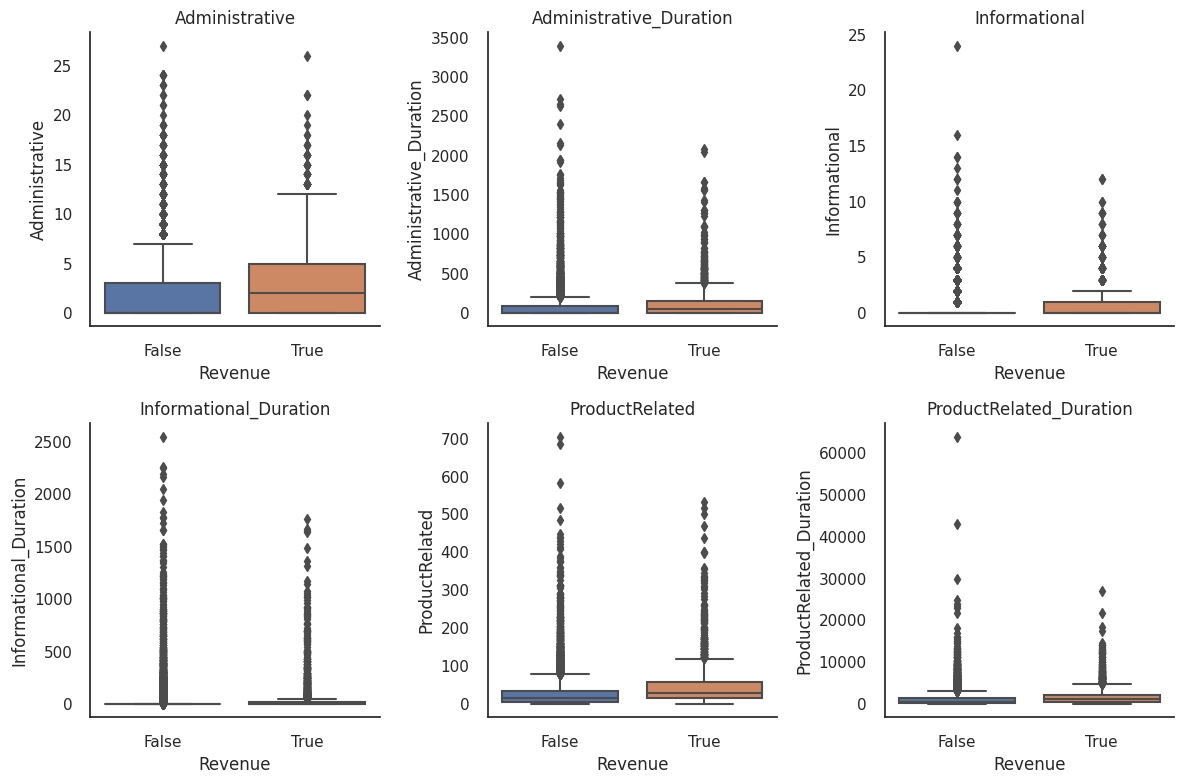

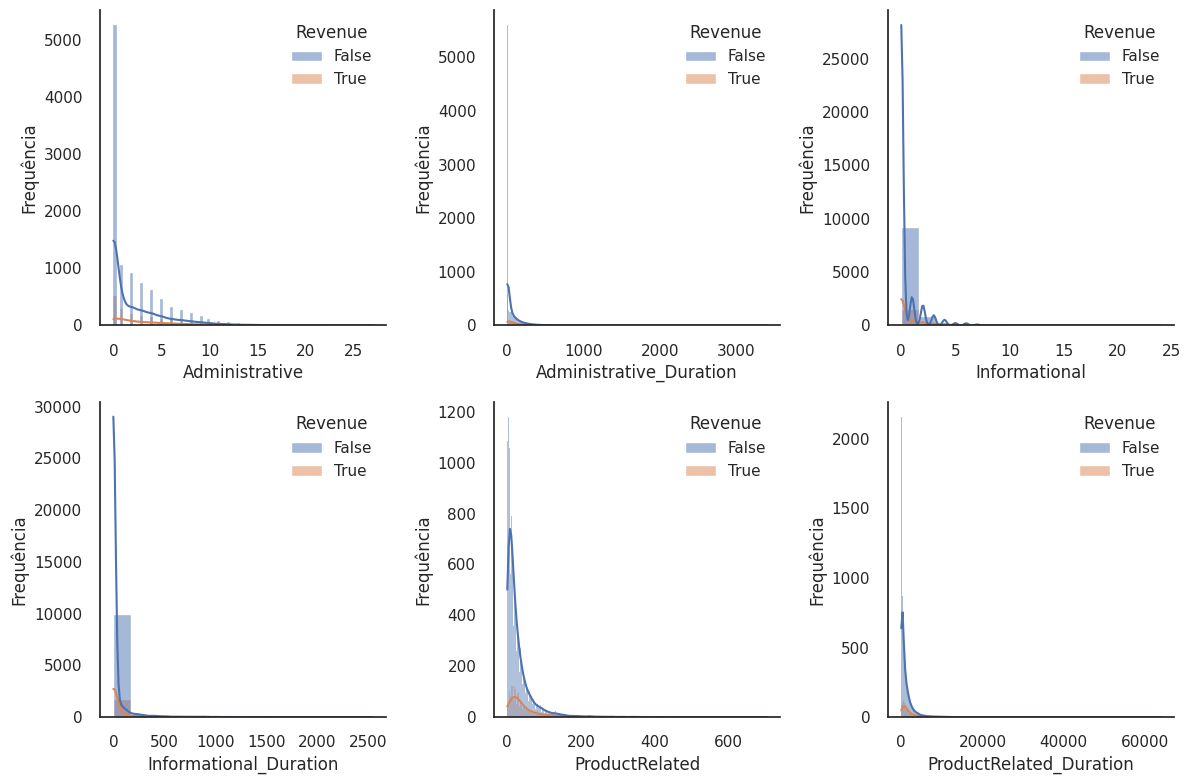

In [4]:
# chama função principal para análise
main_analise(df=df)

A flag 'Revenue' indica se o cliente realizou a compra, ou não, após o acesso ao site.

Observações:
* A maioria dos clientes se encontram entre 0 e 5 acessos, para Adm e Info.
* Clientes passam mais tempo em páginas de produtos.
* Observando os acessos relacionados a produto, existe um pico de acessos de maior compra e, quase para o mesmo número de clientes, para desistências de compra.

#### Função para soma acumulada

In [5]:
"""
Função que calcula a soma acumulada de uma dada coluna em função de outra. 
O gráfico aponta qual o número de usuários que corresponde a 90% dos usuários para cada
situação.
"""

def plot_cum_sum(df, column_grupo, column_valor):

    
    # Separando o dataset com base na coluna de grupo
    grupo_true = df[df[column_grupo] == True]
    grupo_false = df[df[column_grupo] == False]

    # Calculando a soma acumulada para cada grupo
    soma_acumulada_true = grupo_true[column_valor].value_counts().sort_index().cumsum()
    soma_acumulada_false = grupo_false[column_valor].value_counts().sort_index().cumsum()

    # Criando o trace para o grupo True
    trace_true = go.Scatter(x=soma_acumulada_true.index, 
                            y=soma_acumulada_true, 
                            mode='lines',
                            name=f'{column_grupo} Verdadeiro', 
                            line=dict(color='blue', width=2))

    # Criando o trace para o grupo False
    trace_false = go.Scatter(x=soma_acumulada_false.index, 
                             y=soma_acumulada_false, 
                             mode='lines',
                             name=f'{column_grupo} Falso', 
                             line=dict(color='red', width=2))

    # valor total dos eixos y
    total_count_true = soma_acumulada_true.max()
    total_count_false = soma_acumulada_false.max()

    # calcula 90%
    threshold_true = total_count_true * 0.9
    threshold_false = total_count_false * 0.9

    # marca os pontos 90%
    x_90_true = soma_acumulada_true[soma_acumulada_true >= threshold_true].index[0]
    x_90_false = soma_acumulada_false[soma_acumulada_false >= threshold_false].index[0]

    
    annotation_true = go.Annotation(x=x_90_true, y=threshold_true, 
                                    text='90%',
                                    showarrow=True, arrowhead=1, arrowcolor='black', 
                                    ax=0, ay=-40)
    annotation_false = go.Annotation(x=x_90_false, y=threshold_false, 
                                     text='90%',
                                    showarrow=True, arrowhead=1, arrowcolor='black', 
                                    ax=0, ay=-40)

    
    layout = go.Layout(title=f'Soma Acumulada de {column_valor}', 
                       xaxis=dict(title=column_valor, color='black'),
                       yaxis=dict(title='Soma Acumulada', color='black'), 
                       legend=dict(font=dict(size=12)),
                       plot_bgcolor='white', 
                       paper_bgcolor='white', 
                       font=dict(color='black'),
                       annotations=[annotation_true, annotation_false])

    # Criando a figura com os traces e layout
    fig = go.Figure(data=[trace_true, trace_false], layout=layout)

    # Exibindo o gráfico interativo
    fig.show()


In [56]:
# Soma acumulada em função do número de acessos com hue=revenue
colunas = ['Administrative', 'Informational', 'ProductRelated']

for col in colunas:
    plot_cum_sum(df, 'Revenue', col)

/home/jesse/.local/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:143: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




Existe um platô de acessos para indicar se o cliente é comprador ou não. 
* Clientes entre 0-150 acessos são 90%+ dos acessos em produtos.
* Não há clientes com compras após ~13 acessos para informação. Esse dado pode ser enviesado ou apenas uma coincidência. 

#### Tranformação do Mês em variável numérica

Possivelmente o mês de compra é uma informação sensível, por isso importante incluir na análise.

In [6]:
# verifica quais meses estão presentes no dataset
df['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [7]:
# mapeamento dos meses
month_mapping = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'June': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

# Aplica o mapeamento
df['Month'] = df['Month'].map(month_mapping)

In [11]:
df['Month'].unique()

array([ 2,  3,  5, 10,  6,  7,  8, 11,  9, 12])

#### Ordem de grandeza / Padronização

A ordem de grandeza das variáveis principais devem ser checadas, para evitar um enviesamento da base de dados.

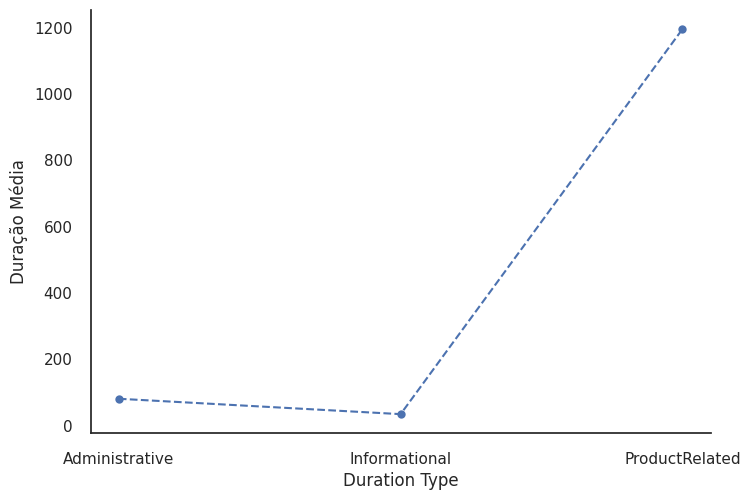

In [57]:
# checando a ordem de grandeza das variáveis
adm_dur = df['Administrative_Duration'].mean()
info_dur = df['Informational_Duration'].mean()
prod_dur = df['ProductRelated_Duration'].mean()
x = range(3)

medias_dur = [adm_dur, info_dur, prod_dur]

plt.plot(x, medias_dur, 'bo--')
plt.xlabel('Duration Type')
plt.ylabel('Duração Média')
plt.xticks(x, ['Administrative', 'Informational', 'ProductRelated'])

plt.show()

Uma possível padronização das médias e desvrio padrão pode beneficiar a análise.

#### Análise Descritiva

Pós padronização

Observando a escala das variáveis ditas principais, padronizar os dados pode ser útil para melhorar a análise do algoritmo kmeans.

In [12]:
# Define um dataset apenas de variaveis numericas e bool
df_num = df.select_dtypes(include=np.number)
df_bool = df.select_dtypes(include=bool)

# Padroniza o dataset, média zero e variância unitária

df_pad_temp = pd.DataFrame(StandardScaler().fit_transform(df_num), columns = df_num.columns)

# Combina a variável numerica com a bool
df_pad = pd.concat([pd.DataFrame(df_pad_temp, columns=df_pad_temp.columns), df_bool], axis=1)
df_pad.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,-1.233426,-0.790293,-0.894178,-0.762629,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-1.665924,-0.136078,-0.207952,-0.894178,-0.514182,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,2.058618,-0.790293,2.437081,-0.265735,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1.665924,0.961270,-0.207952,-0.477771,-0.017289,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1.665924,0.961270,0.374389,-0.894178,-0.017289,True,False


In [14]:
# Conferindo a padronização
df_pad.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType
count,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04
mean,-2.996612e-17,6.281359e-17,-4.610172e-18,-2.535595e-17,4.610172e-17,-8.298309e-17,-6.454241e-17,3.688137e-17,1.060340e-16,-5.532206e-17,-2.212882e-16,4.610172e-18,1.498306e-17,7.722038e-17,-2.996612e-17
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-7.134884e-01,-6.243475e-01,-4.576830e-01,-8.863706e-01,-3.171778e-01,-3.088214e-01,-1.665924e+00,-1.233426e+00,-7.902929e-01,-8.941785e-01,-7.626290e-01
25%,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-5.560920e-01,-5.281214e-01,-4.576830e-01,-5.923930e-01,-3.171778e-01,-3.088214e-01,-7.816737e-01,-1.360783e-01,-2.079519e-01,-8.941785e-01,-5.141822e-01
50%,-3.959377e-01,-4.147639e-01,-3.964779e-01,-2.449305e-01,-3.087548e-01,-3.113566e-01,-3.934903e-01,-3.686913e-01,-3.171778e-01,-3.088214e-01,-1.921733e-01,-1.360783e-01,-2.079519e-01,-6.136354e-02,-5.141822e-01
75%,5.072280e-01,7.035981e-02,-3.964779e-01,-2.449305e-01,1.409492e-01,1.407881e-01,-1.109348e-01,1.425510e-01,-3.171778e-01,-3.088214e-01,9.868275e-01,9.612698e-01,-2.079519e-01,3.550439e-01,-1.728851e-02
max,7.431499e+00,1.876956e+01,1.849960e+01,1.786868e+01,1.513858e+01,3.280678e+01,3.667189e+00,3.229316e+00,1.916634e+01,4.718598e+00,1.281578e+00,6.448010e+00,6.197799e+00,2.437081e+00,3.957861e+00


##### Outliers

In [94]:
# removendo pontos 'outliers'

# IQR
Q1 = np.percentile(df_num, 25)
Q3 = np.percentile(df_num, 75)
IQR = Q3 - Q1

# fronteiras 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
filtered_data = df_num[(df_num >= lower_bound) & (df_num <= upper_bound)]
print(filtered_data.shape)

(12330, 15)


Não houve perda de dados ao remover os outliers.

## Número de grupos - Kmeans

#### Kmeans

##### Função principal Kmeans

In [18]:
"""

Função para calcular e plotar o algoritmo kmeans para um dado número de cluters

"""
def kmeans_analise(df, min_clusters, max_clusters):


    # copia o df original
    X = df.copy()

    # define numero de clusters min e max
    K = range(min_clusters, max_clusters + 1)

    # metricas importantes do modelo
    inertias = []
    silhouettes = []
    cluster_centers = []
    label_models = []

    # loop para capturar as caracteristicas do modelo
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(X)

        cluster_centers.append(kmeans.cluster_centers_)
        inertias.append(kmeans.inertia_)
        label_models.append(kmeans.labels_)
        silhouette_media = silhouette_score(X, kmeans.labels_)
        silhouettes.append(silhouette_media)

        # plota gráfico dos centros para cada modelo
        plot_cluster_centers(kmeans)

    # plota gráfico de métricas
    plot_metrica(K, inertias, silhouettes)

def plot_cluster_centers(kmeans):

    
    fig, ax = plt.subplots(figsize=(3, 3))
    scatter_centers = ax.scatter(kmeans.cluster_centers_[:, 0], 
                                 kmeans.cluster_centers_[:, 1], 
                                 s=100,
                                 marker='^', 
                                 c=range(kmeans.n_clusters), 
                                 linewidth=2, cmap='Paired')

    # configura o label do cluster
    for i, center in enumerate(kmeans.cluster_centers_):
        ax.text(center[0], center[1], 
                f'Cluster {i}', 
                fontsize=10, 
                ha='center', 
                va='bottom')

    ax.grid(False)
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
    ax.set_title(f'Centroide')

    plt.tight_layout()
    plt.show()

def plot_metrica(K, inertias, silhouettes):


    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(K, inertias, 'bo-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')

    ax2.plot(K, silhouettes, 'bo-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Média')

    plt.title('Método do Cotovelo / Silhouette Média')
    plt.tight_layout()
    plt.show()


##### Algoritmo Kmeans

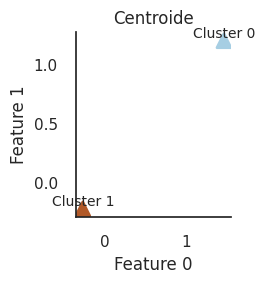

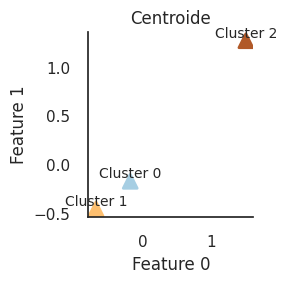

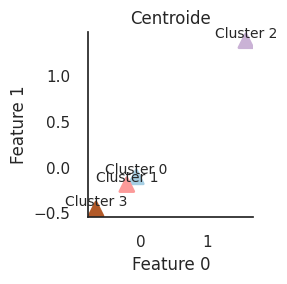

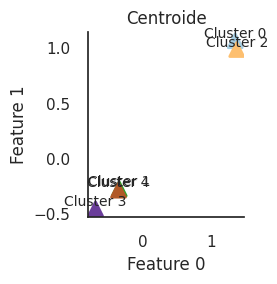

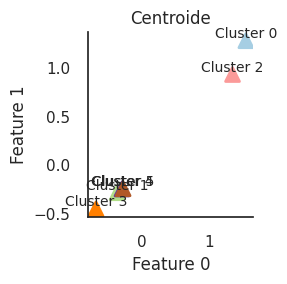

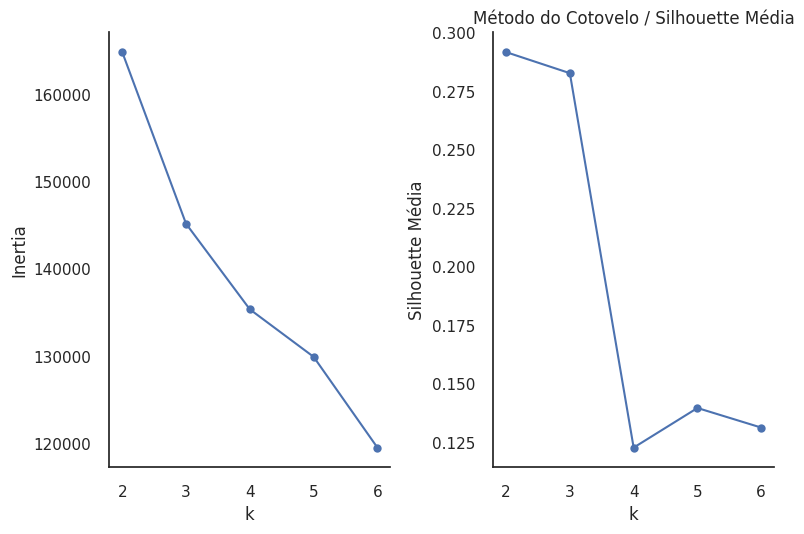

In [19]:
# perfoma o algoritmo kmeans
kmeans_analise(df_pad, 2, 6)

Como visto nos gráficos, um número a 3 clusters não é necessário, já que estes começam a se acumular muito próximos.

##### Yellowbrick - Elbow

Usando o método do cotovelo, implementado na biblioteca *yellowbric*, para ter uma indicação numérica.

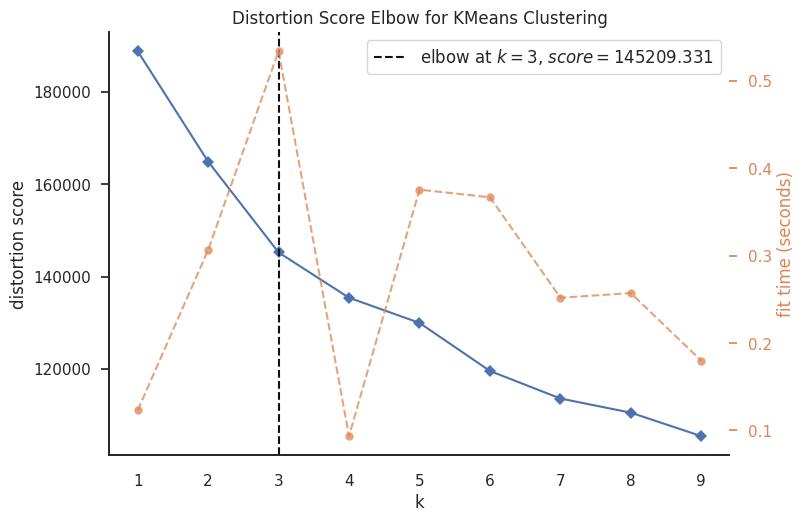

CPU times: user 4.48 s, sys: 2.16 s, total: 6.63 s
Wall time: 9.79 s


In [20]:
%%time

# copia o dataset original
X = df_pad.copy()

# Create K-means model
kmeans_elbow = KMeans(n_init='auto', random_state=42)

# Apply the kelbow visualizer
visualizer = KElbowVisualizer(kmeans_elbow, k=(1, 10))
visualizer.fit(X)

# Visualize the elbow curve
visualizer.show();

A medida de distorção, eixo y, calcula a soma das distâncias ao quadrado (norma euclidiana) de cada ponto até o seu centro. Isto é, calcula a inertia fornecida pelo scikit-learn. Quanto menor, melhor. Mas deve ser associada com outra métrica.



#### Escolha de k

Dado que o valor da silhouete média é maior para o valor 3 (depois do valor 2) e que o método do cotovelo, visual e analiticamente, indicam o **número de clusters igual a 3**.

4 também seria uma opção, porém não tão ideal.

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

#### Função para plotar os dados em função da variável resposta

In [45]:
# função para o plot
def create_plot(df: pd.DataFrame, hue: str, column1='Administrative', column2='Informational', column3='ProductRelated'):


    fig = px.scatter(df, x=hue, y=[column1, column2, column3])
    fig.update_layout(
        xaxis_title=f'{hue} (%)',
        yaxis_title='Média de Acessos',
        title=f'{column1}, {column2}, {column3} em função de {hue}'
    )
    fig.show()

    return None

#### Função para testar os clusters

In [49]:
"""
Função que recebe o df original e o df padronizado para perfomar o algoritmo Kmeans
e plota os resultados em função das variáveis Revenue e BounceRates

"""

def agrupar_e_agregar(df, df_pad, k):


    # copia os dados originais para Y
    Y = df_pad.copy()

    # modelo
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(Y)

    # adiciona os rótulos resultantes do agrupamento a uma cópia do dataframe original
    X = df.copy()
    X['k_' + str(k)] = kmeans.labels_

    # agrupa com base na média de cada rótulo
    agrupado = X.select_dtypes(include=[np.number, bool]).groupby('k_' + str(k)).mean()

    create_plot(agrupado, 'Revenue')
    create_plot(agrupado, 'BounceRates')
    
    return agrupado

#### Testando para k = 3.

In [48]:
agrupar_e_agregar(df, df_pad, 3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
k_3,,,,,,,,,,,,,,,,,
0,1.715649,51.493301,0.215182,8.120499,23.878357,873.976165,0.009116,0.032075,5.883080,0.061433,7.559266,2.119257,2.384528,3.199419,4.047081,0.235922,0.148916
1,0.053875,1.518463,0.016068,0.091871,3.123819,58.614883,0.165908,0.179712,0.000000,0.113233,6.800567,2.183365,2.323251,3.049149,5.051985,0.167297,0.005671
2,7.332719,305.915921,2.527317,212.794042,96.798649,3831.463588,0.006253,0.019430,9.750774,0.027747,8.753837,2.113567,2.216697,2.903008,3.564764,0.255371,0.286065


#### Testando para k=4

In [50]:
agrupar_e_agregar(df, df_pad, 4)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
k_4,,,,,,,,,,,,,,,,,
0,2.064938,63.041081,0.256385,9.330550,27.737676,1018.216759,0.008844,0.029842,7.790343,0.000000,10.733122,2.145318,2.416155,3.269452,4.206296,0.243912,0.199564
1,1.587907,48.170226,0.236679,10.160482,21.722810,794.896156,0.010713,0.035937,4.102920,0.126921,4.415286,2.095789,2.342047,3.111754,3.870684,0.226701,0.100978
2,7.589955,326.548149,2.787856,245.128845,104.840330,4169.891460,0.006309,0.019351,9.524585,0.026237,8.680660,2.109445,2.221889,2.864318,3.643928,0.256372,0.292354
3,0.036403,1.152819,0.009636,0.000000,2.608137,45.340682,0.178641,0.186790,0.000000,0.092505,6.885439,2.180942,2.311563,3.082441,5.005353,0.169165,0.004283


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

Adotando três clusters, o grupo 2 apresenta maior média de compras, 28%. Esse grupo possui as seguintes característica: 
* 100 acessos em média, em páginas de produto com 3831s de média por acesso
* 7 acessos em média, em páginas administrativas com 305s de média por acesso
* 2 acessos em média, em páginas informativas com 212s de média por acesso

##### Observação

Se for necessário incluir informações sobre qual o mês do acesso, uma nova análise Kmeans deve ser feita sem a feature. Pois os agrupamentos, em testes prévios, resultam em valores ótimos de clusterin diferentes.